/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Completed in  12  minutes and  52 seconds.


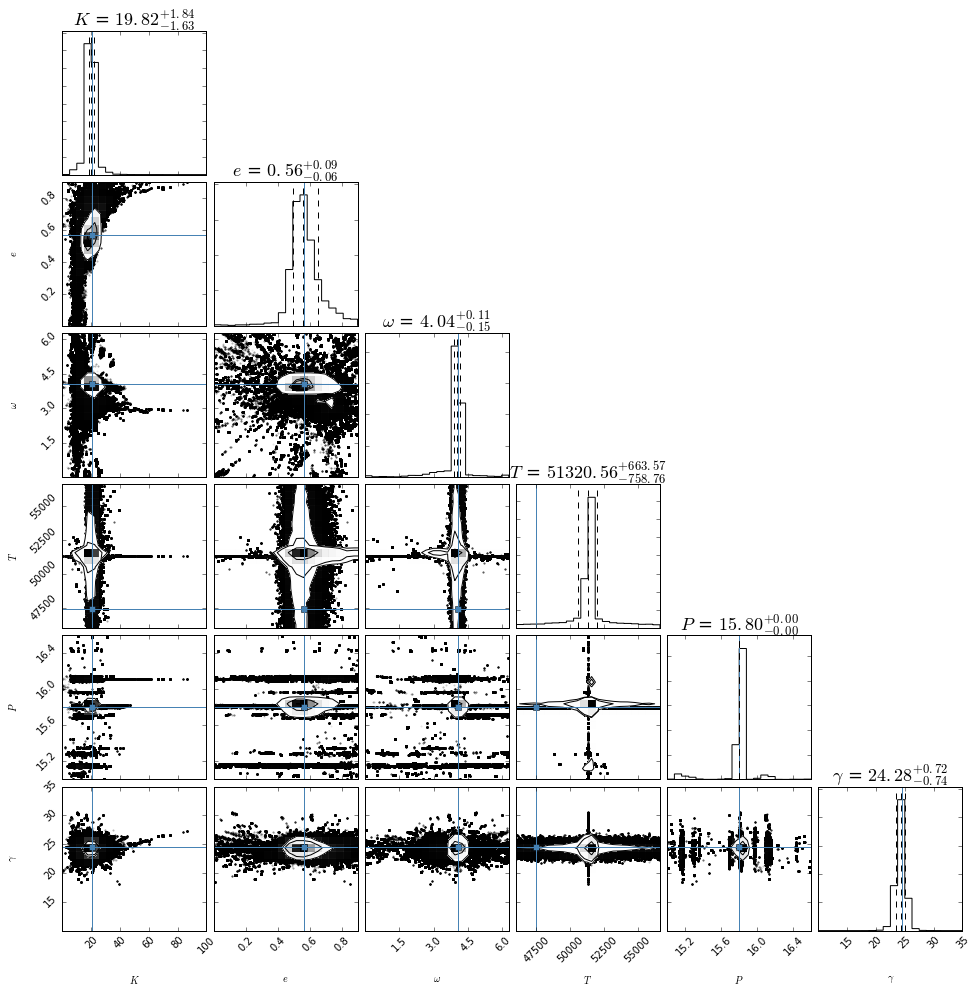

In [6]:
#this is pretty messy, I intend to go through and cleanup / annotate soon
#This code is built from the example found here: http://dan.iel.fm/emcee/current/user/line/#results
import time
t0 = time.time()
import numpy as np
import emcee
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import functions as f
import corner
%matplotlib inline
filename     = 'DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV
residuals   = f.residuals
constraints = f.constraints

for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break

mass_ratio = 0.898896068135

lower_bounds = [0, 0, 0, JD[0], 15, 10]
upper_bounds = [100, 0.9, 2*np.pi, JD[-1], 16.6, 35]


def initialGuess(lower, upper):
    def alteredRV(x, K, e, w, T, P, y): #function generates RV values plot from given parameters
        M = (2*np.pi/P)*(x-T) #Mean Anomaly is a function of time
        E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
        while True: #iteratively refines estimate of E1 from initial estimate
            E0 = E1
            M0 = E0 - e*np.sin(E0)
            E1 = E0 +(M-M0)/(1-e*np.cos(E0))
            if np.amax(E1-E0) < 1E-9:
                break
        nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
        p = ((K)*(np.cos(nu+w) + (e*np.cos(w)))+y)
        return p
    return curve_fit(alteredRV, JDp, np.asarray(RVp), bounds=(lower, upper))[0]

initial_guess = initialGuess(lower_bounds, upper_bounds)

def likelihood(parameters, mass_ratio, primary, secondary):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

#function is poorly named, returns the negative infinity if parameters lie outside contraints, otherwise
#returns the output from residuals()
def probability(initial_guess, mass_ratio, RVp, RVs, lower, upper):
    con = constraints(initial_guess, lower, upper)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(initial_guess, mass_ratio, RVp, RVs)

#set dimensionality and walker number
ndim, nwalkers, nsteps = 6, 1000, 20000

#initialize walkers 
position = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

#walkers distributed in gaussian ball around most likely parameter values
for i in range(0, nwalkers-1):
    position[i][0] = initial_guess[0] + 2.5*np.random.randn(1) #K
    position[i][1] = initial_guess[1] + 0.1*np.random.randn(1) #e
    position[i][2] = initial_guess[2] + 1  *np.random.randn(1) #w
    position[i][3] = initial_guess[3] + 2  *np.random.randn(1) #T
    position[i][4] = initial_guess[4] + 0.1*np.random.randn(1) #P
    position[i][5] = initial_guess[5] + 3  *np.random.randn(1) #y


sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(mass_ratio, RVp, RVs, lower_bounds, upper_bounds), threads = 4)
sampler.run_mcmc(position, nsteps)

#create the corner plot
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$K$", "$e$", "$\omega$", "$T$", "$P$", "$\gamma$"],
                    extents=[[lower_bounds[0], upper_bounds[0]], [lower_bounds[1], upper_bounds[1]], [lower_bounds[2], upper_bounds[2]],
                             [lower_bounds[3], upper_bounds[3]], [lower_bounds[4], upper_bounds[4]], [lower_bounds[5], upper_bounds[5]]],
                    truths = [20.28, 0.568, 4.047, 47433.507, 15.800905, 24.52],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
#fig.savefig("triangle.png")

t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')

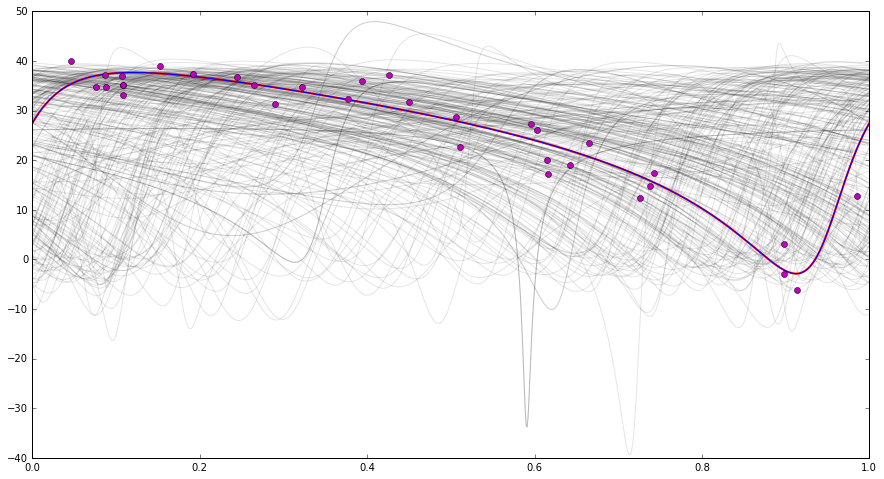

In [5]:
x = np.linspace(0, 15.800905, num=1000)
plt.figure(figsize=(15,8))
for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=250)]:
    parameters = K, e, w, T, P, y
    primary = RV(x, mass_ratio, parameters)[0]
    plt.plot(x/parameters[4], RV(x, mass_ratio, parameters)[0], color="k", alpha=0.1)

#plt.plot(x/parameters[4], RV(x, mass_ratio, initial_guess)[0], color="b", lw=2) #initial guess curve

czekala = RV(x, mass_ratio, [20.28, 0.568, 4.047, 47433.507, 15.800905, 24.52])[0]
plt.plot(x/15.800905, czekala, color="r", lw=2) #Czekala et al. result

Czekala = RV(x, mass_ratio, [19.78, 0.56, 4.04, 51320.56, 15.8, 24.28])[0] 
plt.plot(x/15.800905, czekala, color="b", lw=1) #Czekala et al. result

plt.plot(phases(15.800905, 0, JDp), RVp, 'mo') #data phased to initial guess period
plt.xlim(0,1)

plt.savefig('results.pdf')